In [81]:
import networkx as nx
import nxviz
import pandas as pd
import numpy as np
import nxviz as nv
import matplotlib.pyplot as plt

from analysis_utils import *
from networkx.algorithms.community import greedy_modularity_communities
from networkx.drawing.nx_pydot import graphviz_layout

In [2]:
# Load the data
disbiome_md_path = '../data/MAGNN_data/disbiome_taxid_mondo.dat'
disbiome_md_df = load_data(disbiome_md_path, colname1="microbe", colname2="disease")
gmmad2_md_path = '../data/MAGNN_data/gmmad2_taxid_mondo.dat'
gmmad2_md_df = load_data(gmmad2_md_path, colname1="microbe", colname2="disease")
md_combined_df = merge_df([disbiome_md_df, gmmad2_md_df])

gmmad2_mm_path = '../data/MAGNN_data/gmmad2_taxid_met.dat'
gmmad2_mm_df = load_data(gmmad2_mm_path, colname1="microbe", colname2="metabolite")
hmdb_mm_path = '../data/MAGNN_data/hmdb_taxid_met.dat'
hmdb_mm_df = load_data(hmdb_mm_path, colname1="microbe", colname2="metabolite")
mm_combined_df = merge_df([gmmad2_mm_df, hmdb_mm_df])

metd_path = "../data/MAGNN_data/hmdb_met_disease.dat"
metd_df = load_data(metd_path,colname1="metabolite", colname2="disease")
metd_df = merge_df([metd_df])

Total count of edges: 
microbe    505325
disease    505325
dtype: int64
Total count of edges: 
microbe       599176
metabolite    599176
dtype: int64
Total count of edges: 
metabolite    27546
disease       27546
dtype: int64


In [3]:
# create networkx graph
G = nx.Graph()

for _, row in md_combined_df.iterrows():
    G.add_edge(row["microbe"], row["disease"])

for _, row in mm_combined_df.iterrows():
    G.add_edge(row['microbe'], row['metabolite'])

for _, row in metd_df.iterrows():
    G.add_edge(row['metabolite'], row['disease'])

In [4]:
density = nx.density(G)
components = nx.number_connected_components(G)
degree_correlation = nx.degree_assortativity_coefficient(G)

print(f"Graph Density: {density*100}% of the possible connections between nodes")
print(f"Number of distinct sub-networks within overall network: {components}")
print(f"Degree Correlation where high-degree nodes are connected to peripheral nodes: {degree_correlation}")

Graph Density: 0.20888576318715205% of the possible connections between nodes
Number of distinct sub-networks within overall network: 27
Degree Correlation where high-degree nodes are connected to peripheral nodes: -0.38043422383946


In [5]:
# calculate degree centrality
degree_centrality = nx.degree_centrality(G)
d_cen_nodes_df = pd.DataFrame(list(degree_centrality.items()), columns=['Node', 'Degree Centrality'])
d_cen_nodes_df.set_index('Node', inplace=True)

In [6]:
# show the top 10 highest node degree centrality
top_degree = d_cen_nodes_df.nlargest(10, 'Degree Centrality')
top_degree

,Degree Centrality
Node,
MONDO:0010543,0.608013
MONDO:0005101,0.198348
MONDO:0005265,0.195948
MONDO:0021085,0.194217
MONDO:0005148,0.190086
MONDO:0005052,0.189843
MONDO:0005260,0.189478
MONDO:0005335,0.189083
MONDO:0005011,0.188506


In [68]:
print(f"Total number of nodes: {len(G.nodes())}")
print(f"Total number of edges: {len(G.edges())}")
one_nbr = nodes_with_m_nbrs(G, 1)
print(f"percent of 1 neighbor node: {len(one_nbr)/len(G.nodes())*100}%")

Total number of nodes: 32923
Total number of edges: 1132047
Number of nodes with 1 neighbor(s): 21884
percent of 1 neighbor node: 66.47024876226347%


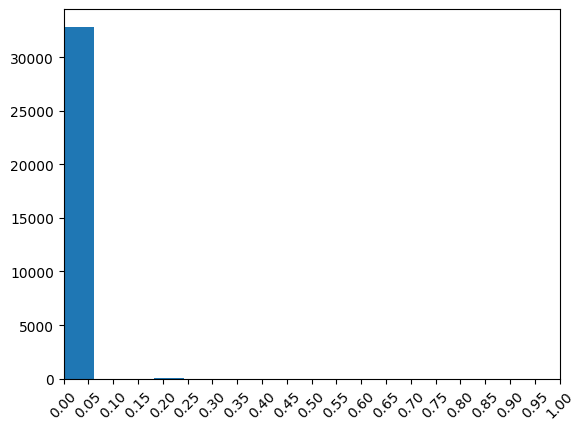

In [47]:
# visualize degree centrality distribution
plt.hist(list(degree_centrality.values()))
plt.xlim(0, 1)
plt.xticks(np.arange(0, 1.05, 0.05), rotation=45)
plt.xlabel("Degree Centrality")
plt.ylabel("Node Degrees")
plt.show()

In [8]:
# calculate the number of neighbors for each node
degrees = [len(list(G.neighbors(node))) for node in G.nodes()]        

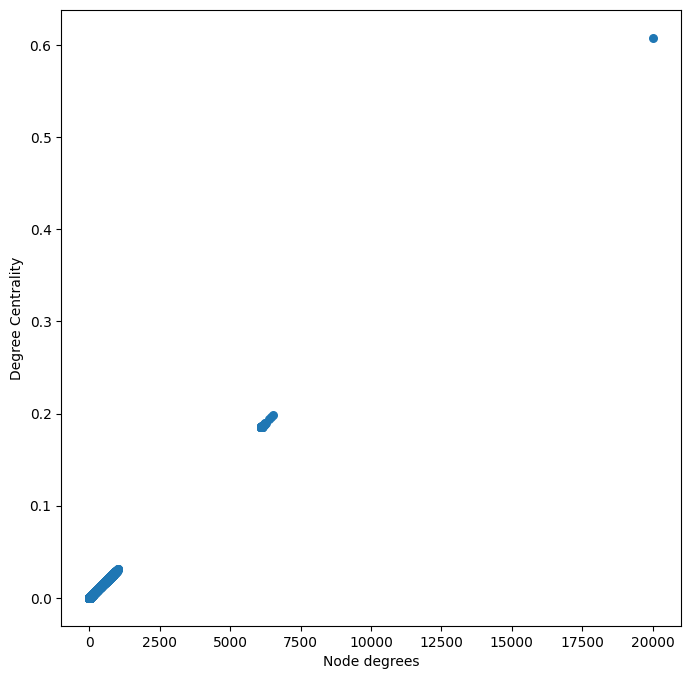

In [9]:
# scatter plot with x as number of node neighbors and y as degree centrality (percent of the total number of connections a node has)
plt.figure(figsize=(8, 8))
plt.scatter(x=degrees, y=list(degree_centrality.values()), s=30)
plt.yticks(np.arange(0, 0.65, 0.05))
plt.xlabel("Node Degrees")
plt.ylabel("Degree Centrality")
plt.show()

In [10]:
# calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

KeyboardInterrupt: 

In [36]:
bet_cen_nodes_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['Node', 'Betweenness Centrality'])
bet_cen_nodes_df.set_index('Node', inplace=True)

In [40]:
bet_cen_nodes_df.get('Betweenness Centrality').nlargest(20)

Node
MONDO:0010543               0.843961
PUBCHEM.COMPOUND:1060       0.471468
MONDO:0005052               0.127275
MONDO:0005147               0.117135
MONDO:0005575               0.038072
MONDO:0013995               0.035093
MONDO:0005101               0.023846
MONDO:0005265               0.013591
MONDO:0021085               0.010704
MONDO:0019182               0.009069
MONDO:0005260               0.008269
MONDO:0005148               0.007991
MONDO:0012451               0.007285
NCBITaxon:562               0.005761
MONDO:0005090               0.004899
MONDO:0008383               0.004599
MONDO:0005335               0.004481
MONDO:0009061               0.004334
MONDO:0005011               0.003753
PUBCHEM.COMPOUND:1551553    0.003317
Name: Betweenness Centrality, dtype: float64

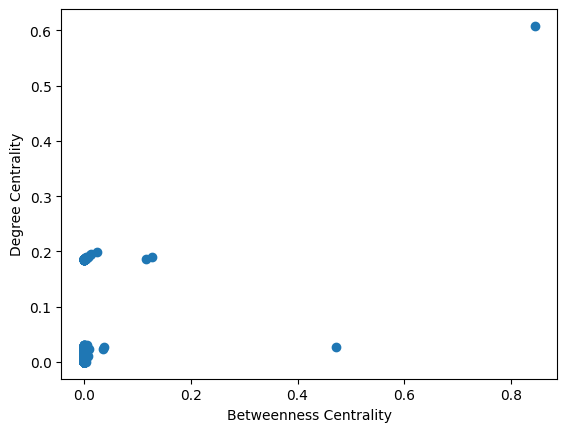

In [32]:
plt.figure()
plt.scatter(x=list(betweenness_centrality.values()), y=list(degree_centrality.values()))
plt.xlabel("Betweenness Centrality")
plt.ylabel("Degree Centrality")
plt.show()

In [11]:
# find the maximal cliques in graph with size 3
mc_3 = maximal_cliques(G, 3)

Number of maximal cliques with size 3: 11121


In [19]:
# look at the subgraph of "MONDO:0005052"
t10_nbrs = set(G.neighbors("MONDO:0005052"))
t10_nbrs = t10_nbrs.union({"MONDO:0005052"})
t10_sub = G.subgraph(t10_nbrs)

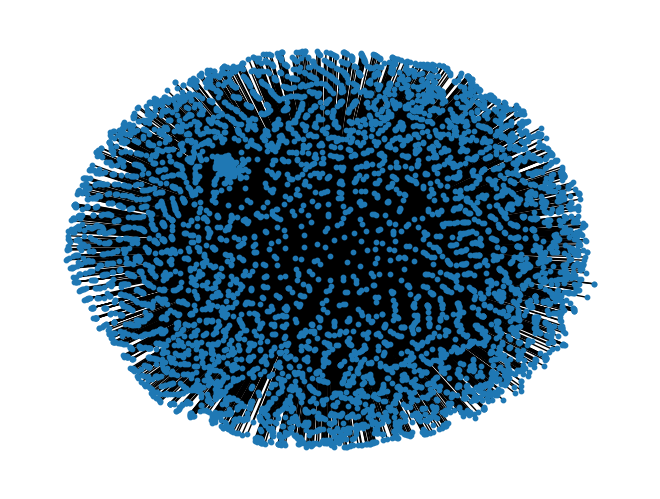

In [25]:
# draw the subgraph of "MONDO:0005052"
nx.draw(t10_sub, node_size=10)
plt.show()

In [71]:
print(f"Total number of nodes of 'MONDO:0005052' subgraph: {len(t10_sub.nodes())}")

Total number of nodes of 'MONDO:0005052' subgraph: 6251


In [72]:
print(f"Total number of edges of 'MONDO:0005052' subgraph: {len(t10_sub.edges())}")

Total number of edges of 'MONDO:0005052' subgraph: 8573


In [49]:
# find connected networks
list(nx.connected_components(G))

[{'PUBCHEM.COMPOUND:446317',
  'NCBITaxon:238',
  'PUBCHEM.COMPOUND:131780037',
  'NCBITaxon:1265693',
  'PUBCHEM.COMPOUND:131786524',
  'NCBITaxon:1322',
  'NCBITaxon:33871',
  'HMDB:HMDB0081932',
  'HMDB:HMDB0078919',
  'HMDB:HMDB0084796',
  'HMDB:HMDB0090297',
  'PUBCHEM.COMPOUND:131796192',
  'PUBCHEM.COMPOUND:131794356',
  'HMDB:HMDB0078018',
  'HMDB:HMDB0091408',
  'PUBCHEM.COMPOUND:131788989',
  'PUBCHEM.COMPOUND:53477720',
  'HMDB:HMDB0083869',
  'PUBCHEM.COMPOUND:131780083',
  'PUBCHEM.COMPOUND:131781030',
  'PUBCHEM.COMPOUND:131787191',
  'HMDB:HMDB0007905',
  'HMDB:HMDB0077290',
  'PUBCHEM.COMPOUND:131783336',
  'PUBCHEM.COMPOUND:131785808',
  'HMDB:HMDB0076827',
  'PUBCHEM.COMPOUND:131783106',
  'PUBCHEM.COMPOUND:131793081',
  'HMDB:HMDB0079233',
  'NCBITaxon:927666',
  'PUBCHEM.COMPOUND:131796431',
  'HMDB:HMDB0077381',
  'PUBCHEM.COMPOUND:131791335',
  'HMDB:HMDB0085902',
  'HMDB:HMDB0090736',
  'PUBCHEM.COMPOUND:131785099',
  'PUBCHEM.COMPOUND:131792417',
  'PUBCHEM.COMP

In [60]:
# calculate the number of nodes in each connected networks
component_sizes = [len(g) for g in nx.connected_components(G)]
component_sizes = sorted(component_sizes, reverse=True)
print(component_sizes)
print(f"Number of distinct connected networks: {len(component_sizes)}")

[32860, 5, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Number of distinct connected networks: 27


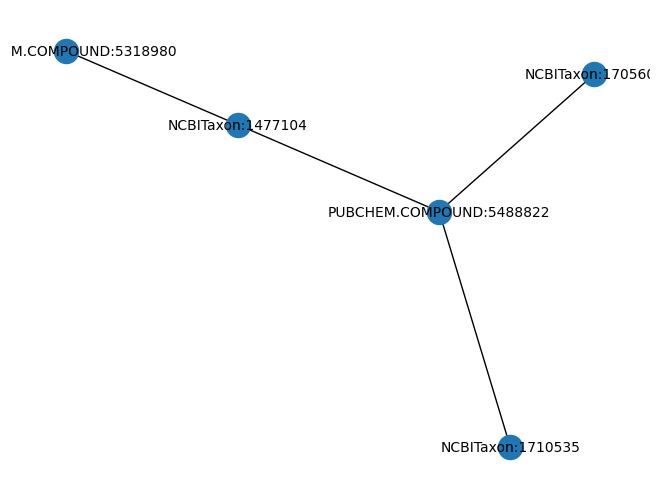

In [79]:
sec_largest_ccs = sorted(nx.connected_components(G), key=lambda x: len(x))[-2]
sec_lccs_h = G.subgraph(sec_largest_ccs)
nx.draw(sec_lccs_h, with_labels=True, font_size=10)
plt.show()

In [ ]:
largest_ccs = sorted((G.subgraph(c) for c in nx.connected_components(G)), key=lambda x: len(x))[-1]
largest_ccs_h = nv.matrix(largest_ccs)
plt.show()